實作: https://blog.csdn.net/qq_39516859/article/details/80505981 <br/>
理論: https://liuyanfeier.github.io/2017/10/07/fbank%E5%92%8Cmfcc%E7%89%B9%E5%BE%81%E6%8F%90%E5%8F%96/ <br/>
理論: https://xingui.cf/%E8%AF%AD%E9%9F%B3%E8%AF%86%E5%88%AB/2018/05/17/MFCC_and_FBank/

In [1]:
import numpy as np 
from scipy import signal
from scipy.fftpack import dct
import pylab as plt

In [2]:
def enframe(wave_data, nw, inc, winfunc):
    '''将音频信号转化为帧。
    参数含义：
    wave_data:原始音频型号
    nw:每一帧的长度(这里指采样点的长度，即采样频率乘以时间间隔)
    inc:相邻帧的间隔（同上定义）
    '''
    wlen=len(wave_data) #信号总长度
    if wlen<=nw: #若信号长度小于一个帧的长度，则帧数定义为1
        nf=1
    else: #否则，计算帧的总长度
        nf=int(np.ceil((1.0*wlen-nw+inc)/inc))
    pad_length=int((nf-1)*inc+nw) #所有帧加起来总的铺平后的长度
    zeros=np.zeros((pad_length-wlen,)) #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal=np.concatenate((wave_data,zeros)) #填补后的信号记为pad_signal
    indices=np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices=np.array(indices,dtype=np.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号
    win=np.tile(winfunc,(nf,1))  #window窗函数，这里默认取1
    return frames*win   #返回帧信号矩阵


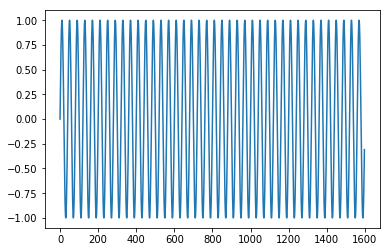

In [3]:
Df=5
fs=8000
N=fs/Df
t = np.arange(0,(N-1)/fs,1/fs)      
wave_data=np.sin(2*np.pi*200*t)
plt.plot(wave_data)
plt.show()

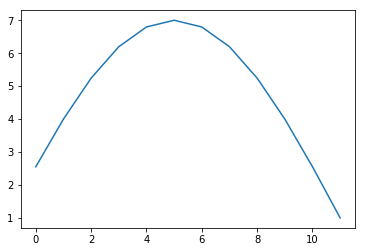

In [4]:
#预加重
#b,a = signal.butter(1,1-0.97,'high')
#emphasized_signal = signal.filtfilt(b,a,wave_data)
#归一化倒谱提升窗口
lifts=[]
for n in range(1,13):
    lift =1 + 6 * np.sin(np.pi * n / 12)
    lifts.append(lift)
plt.plot(lifts)
plt.show()  

In [5]:
#分帧、加窗 
winfunc = signal.hamming(256) 
X=enframe(wave_data, 256, 80, winfunc)    #转置的原因是分帧函数enframe的输出矩阵是帧数*帧长
frameNum =X.shape[0] #返回矩阵行数18，获取帧数
print(X.shape[1])
 

256


In [6]:
y=X[1,:]
#fft
yf = np.abs(np.fft.fft(y))
yf = yf**2
print(yf.shape)

(256,)


In [7]:

for i in range(frameNum):
    y=X[i,:]
    #fft
    yf = np.abs(np.fft.fft(y)) 
    #print(yf.shape)
    #谱线能量
    yf = yf**2
    #梅尔滤波器系数
    nfilt = 24
    low_freq_mel = 0
    NFFT=256
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # 把 Hz 变成 Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 将梅尔刻度等间隔
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # 把 Mel 变成 Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(yf[0:129], fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # 数值稳定性
    filter_banks = 10 * np.log10(filter_banks)  # dB 
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    print(filter_banks.shape)
    '''
    #DCT系数
    num_ceps = 12
    c2 = dct(filter_banks, type=2, axis=-1, norm='ortho')[ 1 : (num_ceps + 1)] # Keep 2-13
    c2 = c2* lifts
    print(c2)
    plt.plot(c2)
    plt.show()
    '''
    

(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
